In [1]:
import random
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy
import plotly.graph_objects as go
import scipy.stats

In [2]:
mpl.style.use("ggplot")
warnings.filterwarnings("ignore")

In [3]:
def get_data(path: str) -> list[float | int]:
    sample_distribution_file = open(path, "r")
    data = [float(x.replace(",", ".")) for x in sample_distribution_file.read().splitlines()]
    sample_distribution_file.close()
    return data

In [4]:
path = "../../datasets_test/continuous/data_1000/data_beta.txt"
data = get_data(path)

In [5]:
ALL_DISTRIBUTIONS = [
    scipy.stats.alpha,
    scipy.stats.anglit,
    scipy.stats.arcsine,
    scipy.stats.beta,
    scipy.stats.betaprime,
    scipy.stats.bradford,
    scipy.stats.burr,
    scipy.stats.cauchy,
    scipy.stats.chi,
    scipy.stats.chi2,
    scipy.stats.cosine,
    scipy.stats.dgamma,
    scipy.stats.dweibull,
    scipy.stats.erlang,
    scipy.stats.expon,
    scipy.stats.exponnorm,
    scipy.stats.exponweib,
    scipy.stats.exponpow,
    scipy.stats.f,
    scipy.stats.fatiguelife,
    scipy.stats.fisk,
    scipy.stats.foldcauchy,
    scipy.stats.foldnorm,
    scipy.stats.genlogistic,
    scipy.stats.genpareto,
    scipy.stats.gennorm,
    scipy.stats.genexpon,
    scipy.stats.genextreme,
    scipy.stats.gausshyper,
    scipy.stats.gamma,
    scipy.stats.gengamma,
    scipy.stats.genhalflogistic,
    scipy.stats.gibrat,
    scipy.stats.gompertz,
    scipy.stats.gumbel_r,
    scipy.stats.gumbel_l,
    scipy.stats.halfcauchy,
    scipy.stats.halflogistic,
    scipy.stats.halfnorm,
    scipy.stats.halfgennorm,
    scipy.stats.hypsecant,
    scipy.stats.invgamma,
    scipy.stats.invgauss,
    scipy.stats.invweibull,
    scipy.stats.johnsonsb,
    scipy.stats.johnsonsu,
    scipy.stats.ksone,
    scipy.stats.kstwobign,
    scipy.stats.laplace,
    scipy.stats.levy,
    scipy.stats.levy_l,
    scipy.stats.logistic,
    scipy.stats.loggamma,
    scipy.stats.loglaplace,
    scipy.stats.lognorm,
    scipy.stats.lomax,
    scipy.stats.maxwell,
    scipy.stats.mielke,
    scipy.stats.nakagami,
    scipy.stats.ncx2,
    scipy.stats.ncf,
    scipy.stats.nct,
    scipy.stats.norm,
    scipy.stats.pareto,
    scipy.stats.pearson3,
    scipy.stats.powerlaw,
    scipy.stats.powerlognorm,
    scipy.stats.powernorm,
    scipy.stats.rdist,
    scipy.stats.reciprocal,
    scipy.stats.rayleigh,
    scipy.stats.rice,
    scipy.stats.recipinvgauss,
    scipy.stats.semicircular,
    scipy.stats.t,
    scipy.stats.triang,
    scipy.stats.truncexpon,
    scipy.stats.truncnorm,
    scipy.stats.tukeylambda,
    scipy.stats.uniform,
    scipy.stats.vonmises,
    scipy.stats.vonmises_line,
    scipy.stats.wald,
    scipy.stats.weibull_min,
    scipy.stats.weibull_max,
    scipy.stats.wrapcauchy,
]

In [6]:
## Calculae Histogram
frequencies, bin_edges = numpy.histogram(data, density=True)
central_values = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]

results = {}
for distribution in ALL_DISTRIBUTIONS:
    ## Get parameters of distribution
    params = distribution.fit(data)

    ## Separate parts of parameters
    args = params[:-2]
    loc = params[-2]
    scale = params[-1]

    ## Calculate fitted PDF and error with fit in distribution
    pdf_values = distribution.pdf(numpy.array(central_values), loc=loc, scale=scale, *args)

    ## Calculate SSE (sum of squared estimate of errors)
    sse = numpy.sum(numpy.power(frequencies - pdf_values, 2.0))

    ## Build results and sort by sse
    results[distribution.name] = {
        "distribution": distribution,
        "parameters": {"loc": loc, "scale": scale, "args": args},
        "sse": sse,
    }

sorted_results = {dist_name: result for dist_name, result in sorted(results.items(), key=lambda x: x[1]["sse"])}

In [27]:
def plot_histogram(data, results, n):
    ## Histogram of data
    plt.figure(figsize=(6, 4))
    plt.hist(data, density=True, bins=8, ec="white", color=(192 / 235, 17 / 235, 17 / 235, 0.6))
    plt.title("HISTOGRAM")
    plt.xlabel("Values", fontsize=10)
    plt.ylabel("Frequencies", fontsize=10)

    ## Plot n distributions
    for distribution_name, result in list(results.items())[:n]:
        loc = result["parameters"]["loc"]
        scale = result["parameters"]["scale"]
        args = result["parameters"]["args"]
        x_plot = numpy.linspace(min(data), max(data), 1000)
        y_plot = result["distribution"].pdf(x_plot, loc=loc, scale=scale, *args)
        plt.plot(x_plot, y_plot, label=f"{distribution_name}: {result['sse']:.2E}", color=(random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)))

    plt.legend(title="DISTRIBUTIONS", bbox_to_anchor=(1.01, 1.01), loc="upper left", fontsize=8)
    plt.show()

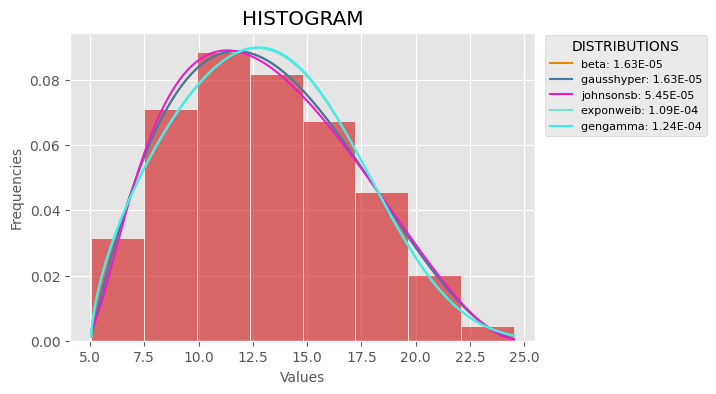

In [28]:
plot_histogram(data, sorted_results, 5)

In [12]:
def plot_histogram_plotly(data, results, n):

    # Histogram of data
    fig = go.Figure()
    fig.add_trace(go.Bar(x=central_values, y=densities_frequencies, marker_color="rgba(192, 17, 17, 0.6)", name="Data", showlegend=False))

    # Plot n distributions
    for idx, (distribution_name, result) in enumerate(list(results.items())[:n]):
        loc = result["parameters"]["loc"]
        scale = result["parameters"]["scale"]
        args = result["parameters"]["args"]
        x_plot = numpy.linspace(min(data), max(data), 1000)
        y_plot = result["distribution"].pdf(x_plot, loc=loc, scale=scale, *args)

        is_visible = True if idx + 1 <= 5 else "legendonly"

        fig.add_trace(go.Scatter(x=x_plot, y=y_plot, mode="lines", visible=is_visible, name=f"{distribution_name}: {result['sse']:.4E}"))

    fig.update_layout(
        height=400,
        width=600,
        title="HISTOGRAM",
        xaxis_title="Values",
        yaxis_title="Frequencies",
        legend_title="DISTRIBUTIONS",
        template="ggplot2",
        legend=dict(orientation="v", yanchor="auto", y=1, xanchor="left", font=dict(size=10)),
        bargap=0.15,
    )

    fig.show()

In [13]:
plot_histogram_plotly(data, sorted_results, 25)